In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [2]:
offers_classed=pd.read_pickle("final_table_nf.pkl")

In [3]:
labels=offers_classed['successful_offer'].values
print(len(labels))

66501


In [4]:
features = offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income', 'female', 'male', 'other','total_spend','transaction','viewed'])
print(len(features))

66501


In [5]:
def quantileScale (df,col):
    col=df.filter(col)
    col_scaled=quantile_transform(col, copy=False)
    col=pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df.update(col)
    return (df)

In [6]:
features.columns

Index(['reward', 'difficulty', 'duration', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'age', 'became_member_on', 'income',
       'female', 'male', 'other', 'total_spend', 'transaction', 'viewed'],
      dtype='object')

Scale all features using the quantile transformation (including the new features added during the benchmark refinement phase)

In [7]:
features=quantileScale(features, ['reward', 'difficulty', 'duration', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'age', 'became_member_on', 'income',
       'female', 'male', 'other', 'total_spend', 'transaction', 'viewed'])

features=features.values


In [8]:
#Convert features and labels to tensors
features = torch.as_tensor(features, dtype=torch.float)
labels = torch.as_tensor(labels, dtype=torch.long)

In [9]:
## Split data into three random datasets 

# Generate randomic indices
len_dataset = len(features)
random_idx = np.random.choice(len_dataset, len_dataset, replace=False)

# Use the proportions: train: 70%, valid: 15%, test: 15%
train_idx = random_idx[:int(len_dataset*0.70)]
valid_idx = random_idx[-int(len_dataset*0.15):]
test_idx = random_idx[int(len_dataset*0.70):-int(len_dataset*0.15)]

# Create datasets
train_dataset = TensorDataset(features[train_idx], labels[train_idx])
valid_dataset = TensorDataset(features[valid_idx], labels[valid_idx])
test_dataset = TensorDataset(features[test_idx], labels[test_idx])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Making sure the split has maintained balanced classes

In [10]:
#Counting the training labels
train_neg = (labels[train_idx] == 0).sum()
train_pos = (labels[train_idx] == 1).sum()
train_total=len(train_idx)
print('Training data has {} unsuccessful events and {} successful events \nThe ratio between classes is:\t {:0.2f} : {:0.2f}\n'.format(train_neg, train_pos, train_neg/train_total, train_pos/train_total))

#Counting the validating labels
valid_neg = (labels[valid_idx] == 0).sum()
valid_pos = (labels[valid_idx] == 1).sum()
valid_total =len(valid_idx)
print('Validation data has {} unsuccessful events and {} successful events \nThe ratio between classes is:\t {:0.2f} : {:0.2f}\n'.format(valid_neg, valid_pos, valid_neg/valid_total, valid_pos/valid_total))

#Counting the testing labels
test_neg = (labels[test_idx] == 0).sum()
test_pos = (labels[test_idx] == 1).sum()
test_total =len(test_idx)
print('Testing data has {} unsuccessful events and {} successful events \nThe ratio between classes is:\t {:0.2f} : {:0.2f}\n'.format(test_neg, test_pos, test_neg/test_total, test_pos/test_total))


Training data has 26615 unsuccessful events and 19935 successful events 
The ratio between classes is:	 0.57 : 0.43

Validation data has 5772 unsuccessful events and 4203 successful events 
The ratio between classes is:	 0.58 : 0.42

Testing data has 5676 unsuccessful events and 4300 successful events 
The ratio between classes is:	 0.57 : 0.43



In [11]:
class LinearNN(nn.Module):
    def __init__(self, input_size, hidden_layers=[128,128],
                 output_size=2, dropout=0.2):
        super(LinearNN, self).__init__()
        self.input_size = input_size

        nodes = []
        nodes.append(input_size)
        nodes.extend(hidden_layers)
        nodes.append(output_size)

        self.module_list = nn.ModuleList()
        for nodes_in, nodes_out in zip(nodes[:-1], nodes[1:]):
            layer = nn.Linear(nodes_in, nodes_out)
            self.module_list.append(layer)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for layer in self.module_list[:-1]:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.module_list[-1](x)

        return x

In [12]:
def validate(model, dataloader=valid_dataloader):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        y_true = []
        y_pred = []
        for features, labels in dataloader:
            prediction = model(features)
            
            prediction = prediction.view(-1,2)
            labels = labels.view(-1)
            valid_loss += criterion(prediction, labels)

            prediction = torch.softmax(prediction, dim=1)
            _, prediction = prediction.topk(1, dim=1)
            prediction = prediction.squeeze()

            y_pred.extend(prediction.view(-1))
            y_true.extend(labels.view(-1))

        # normalize the loss
        valid_loss /= len(dataloader)
        valid_loss = valid_loss.item()

        con_mat = confusion_matrix(y_true, y_pred)
        class_report=classification_report(y_true, y_pred, digits=4, target_names=['unsuccessful','successful'],output_dict=False)
        
        model.train()

        return valid_loss, con_mat, class_report
    


In [13]:
def train(model, model_name='classifier',
          dataloader=train_dataloader, epochs=200):
    train_loss = []
    valid_loss = []
    min_valid_loss = np.inf
    
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, labels) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,2)
            labels = labels.view(-1)
            loss = criterion(prediction, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the training loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        
        # LR scheduler step
        lr_scheduler.step(train_loss[-1])

        # Validate
        metrics = validate(model)
        valid_loss.append(metrics[0])
        print('Epoch {:4d}\ttrain loss: {:7.4f}\tvalidation loss: {:7.4f}' \
              .format(epoch, train_loss[-1], valid_loss[-1]))

        # Only save the model if valid_loss has decreased
        if valid_loss[-1] < min_valid_loss:
            min_valid_loss = valid_loss[-1]
            torch.save(model.state_dict(), model_name+'.pt')

    return train_loss, valid_loss

In [14]:
NNclassifier = LinearNN(input_size=18, output_size=2, hidden_layers=[256,256,256])

criterion = nn.CrossEntropyLoss(torch.tensor([(float(train_neg) / float(train_pos)), 1])) 

optimizer = torch.optim.Adam(NNclassifier.parameters(), lr=0.0001, weight_decay=0.0001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=15, verbose=True)

In [15]:
%%time 
#100 takes 12min 8s
#200 takes 27min 9s

linear_loss = train(NNclassifier, model_name='NN_classifier', epochs=60)

Epoch    1	train loss:  0.5915	validation loss:  0.5649
Epoch    2	train loss:  0.5697	validation loss:  0.5550
Epoch    3	train loss:  0.5624	validation loss:  0.5503
Epoch    4	train loss:  0.5578	validation loss:  0.5476
Epoch    5	train loss:  0.5552	validation loss:  0.5500
Epoch    6	train loss:  0.5520	validation loss:  0.5443
Epoch    7	train loss:  0.5505	validation loss:  0.5443
Epoch    8	train loss:  0.5489	validation loss:  0.5465
Epoch    9	train loss:  0.5474	validation loss:  0.5422
Epoch   10	train loss:  0.5466	validation loss:  0.5401
Epoch   11	train loss:  0.5445	validation loss:  0.5398
Epoch   12	train loss:  0.5440	validation loss:  0.5371
Epoch   13	train loss:  0.5419	validation loss:  0.5392
Epoch   14	train loss:  0.5418	validation loss:  0.5363
Epoch   15	train loss:  0.5412	validation loss:  0.5361
Epoch   16	train loss:  0.5411	validation loss:  0.5362
Epoch   17	train loss:  0.5392	validation loss:  0.5363
Epoch   18	train loss:  0.5397	validation loss: 

In [16]:
#evaluation metrics
loss, con_mat, class_report=  validate(NNclassifier, test_dataloader)

In [17]:
print(class_report)

              precision    recall  f1-score   support

unsuccessful     0.7085    0.8474    0.7718      5676
  successful     0.7283    0.5398    0.6200      4300

    accuracy                         0.7148      9976
   macro avg     0.7184    0.6936    0.6959      9976
weighted avg     0.7170    0.7148    0.7064      9976



<AxesSubplot:>

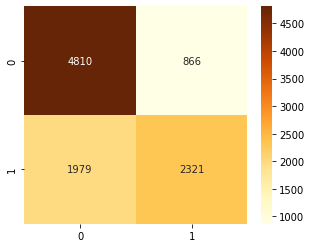

In [18]:
plt.figure(figsize = (5,4))
sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

<font size=4>Refinement and Optimising for Recall<font/>

In [19]:
NNclassifier = LinearNN(input_size=18, output_size=2, hidden_layers=[256,256,256])

criterion = nn.CrossEntropyLoss(torch.tensor([(float(train_neg) / float(1.35*train_pos)), 1])) 

optimizer = torch.optim.Adam(NNclassifier.parameters(), lr=0.0001, weight_decay=0.0001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=15, verbose=True)

In [20]:
%%time 
#200 takes 16min 35s

linear_loss = train(NNclassifier, model_name='NNclassifier', epochs=60)

Epoch    1	train loss:  0.6155	validation loss:  0.5880
Epoch    2	train loss:  0.5935	validation loss:  0.5798
Epoch    3	train loss:  0.5867	validation loss:  0.5758
Epoch    4	train loss:  0.5835	validation loss:  0.5720
Epoch    5	train loss:  0.5792	validation loss:  0.5677
Epoch    6	train loss:  0.5759	validation loss:  0.5665
Epoch    7	train loss:  0.5748	validation loss:  0.5692
Epoch    8	train loss:  0.5726	validation loss:  0.5653
Epoch    9	train loss:  0.5701	validation loss:  0.5644
Epoch   10	train loss:  0.5699	validation loss:  0.5624
Epoch   11	train loss:  0.5678	validation loss:  0.5629
Epoch   12	train loss:  0.5661	validation loss:  0.5604
Epoch   13	train loss:  0.5660	validation loss:  0.5608
Epoch   14	train loss:  0.5652	validation loss:  0.5598
Epoch   15	train loss:  0.5642	validation loss:  0.5589
Epoch   16	train loss:  0.5635	validation loss:  0.5603
Epoch   17	train loss:  0.5626	validation loss:  0.5585
Epoch   18	train loss:  0.5623	validation loss: 

In [21]:
#evaluation metrics
loss, con_mat, class_report=  validate(NNclassifier, test_dataloader)

In [22]:
print(class_report)

              precision    recall  f1-score   support

unsuccessful     0.7390    0.7881    0.7627      5676
  successful     0.6933    0.6326    0.6616      4300

    accuracy                         0.7210      9976
   macro avg     0.7162    0.7103    0.7121      9976
weighted avg     0.7193    0.7210    0.7191      9976



<AxesSubplot:>

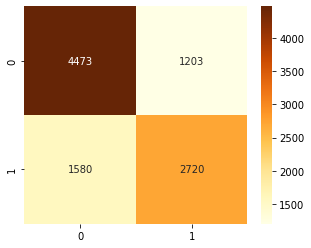

In [23]:
plt.figure(figsize = (5,4))
sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

In [ ]:
# Benchmark 
#Best parameters for recall found on training set are:
#{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
#
#precision    recall  f1-score   support

#unsuccessful     0.7303    0.7918    0.7598      5677
#  successful     0.6907    0.6139    0.6500      4299

#    accuracy                         0.7151      9976
#   macro avg     0.7105    0.7028    0.7049      9976
#weighted avg     0.7132    0.7151    0.7125      9976